# Isoplane320 Wavelength Calibration Test

Configure the matplotlib backend for high-resolution retina display.

Import necessary libraries, including `kspecdr` modules for instrument handling, IO, preprocessing, tramline mapping, extraction, and calibration. Also define the working directory and resource paths.

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.signal import find_peaks_cwt, find_peaks
from rascal.util import refine_peaks
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.tlm.make_tlm import read_instrument_data, make_tlm
from kspecdr.extract.make_ex import make_ex
from kspecdr.extract.reduce_arc import reduce_arcs
from kspecdr.wavecal.arc_io import read_arc_file

plt.rcParams["figure.dpi"] = 300

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_arctest_20251224"

/home/hbahk/miniconda3/envs/twodfdr/lib/python3.12/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load a raw fiber flat field image. Since the raw data from the laboratory might not have the standard headers expected by the pipeline, we convert the header using `convert_isoplane_header`, add a dummy fiber table using `add_fiber_table`, and save the result as a new FITS file suitable for processing.

In [2]:
hdul = fits.open(TESTDIR / "flat_150_490_1sec 2025-12-24.fits")
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "flat_150_490_1sec_converted.fits"
hdul.writeto(new_fpath, overwrite=True)
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     188   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   16R x 2C   ['1A', '20A']   


Inspect the fiber table extension of the converted FITS file to ensure the fiber definitions are correct.

In [3]:
Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


```{note}
Fibre status codes used in the configuration are defined as follows:

- **F**: Fiducial star (guide fibre).
- **N**: Not in use. The fibre is broken, dead, or otherwise unusable. These fibres are not placed on the focus plate, but may still receive some vignetted light from a random sky position.
- **P**: Program (science) target.
- **S**: Sky fibre, used for sky background measurements.
- **U**: Unallocated (unused) fibre. These fibres are not part of the current fibre configuration. In previous observations, they may or may not have been placed on the focus plate. Currently, they are always parked at the plate edge. If on the plate, they observe a random sky position; if off the plate, they may still receive vignetted light from a random sky position.
```

Display the raw image data to visually verify the input.

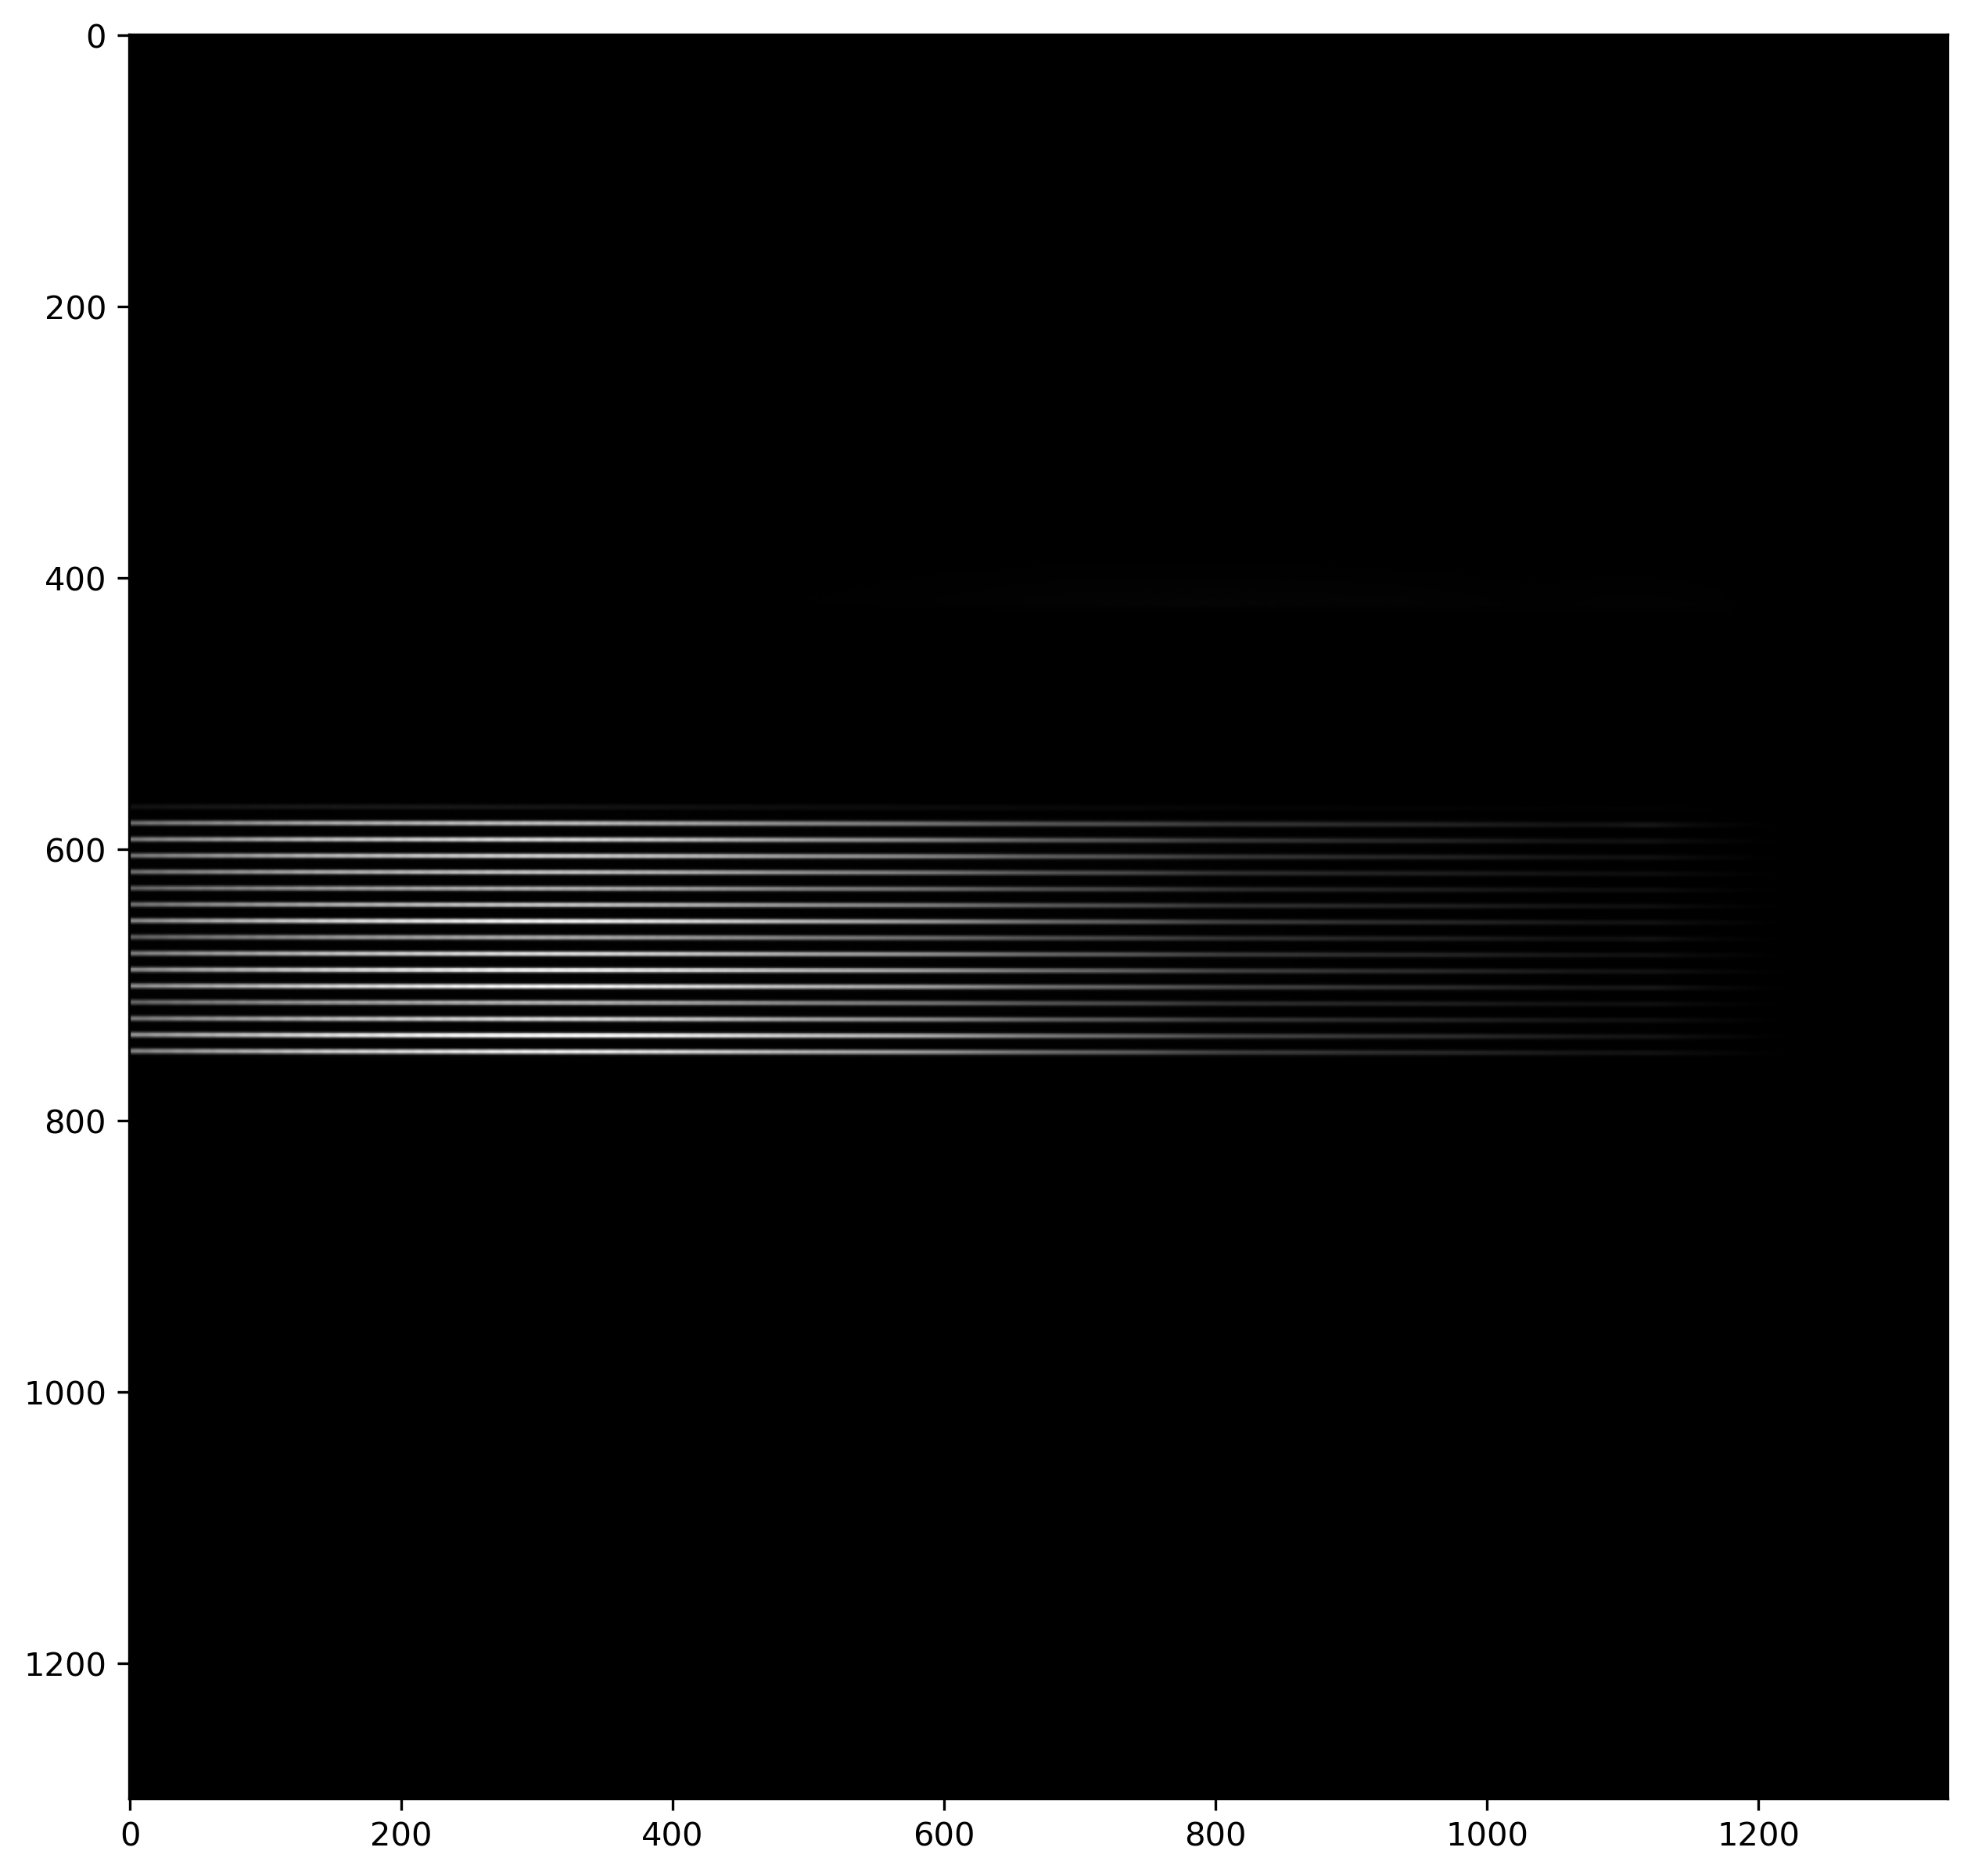

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

Run `make_im` to preprocess the image. This step performs tasks such as bias subtraction and cosmic ray rejection (disabled here), creating an 'im' file.

In [5]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode="READ")
im.open()

make_im(new_fpath.as_posix(), cosmic_ray_method="NONE", verbose=False)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (

INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits


'/data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits'

Load the preprocessed image ('im' file) and display it. This image serves as the input for tramline mapping.

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)


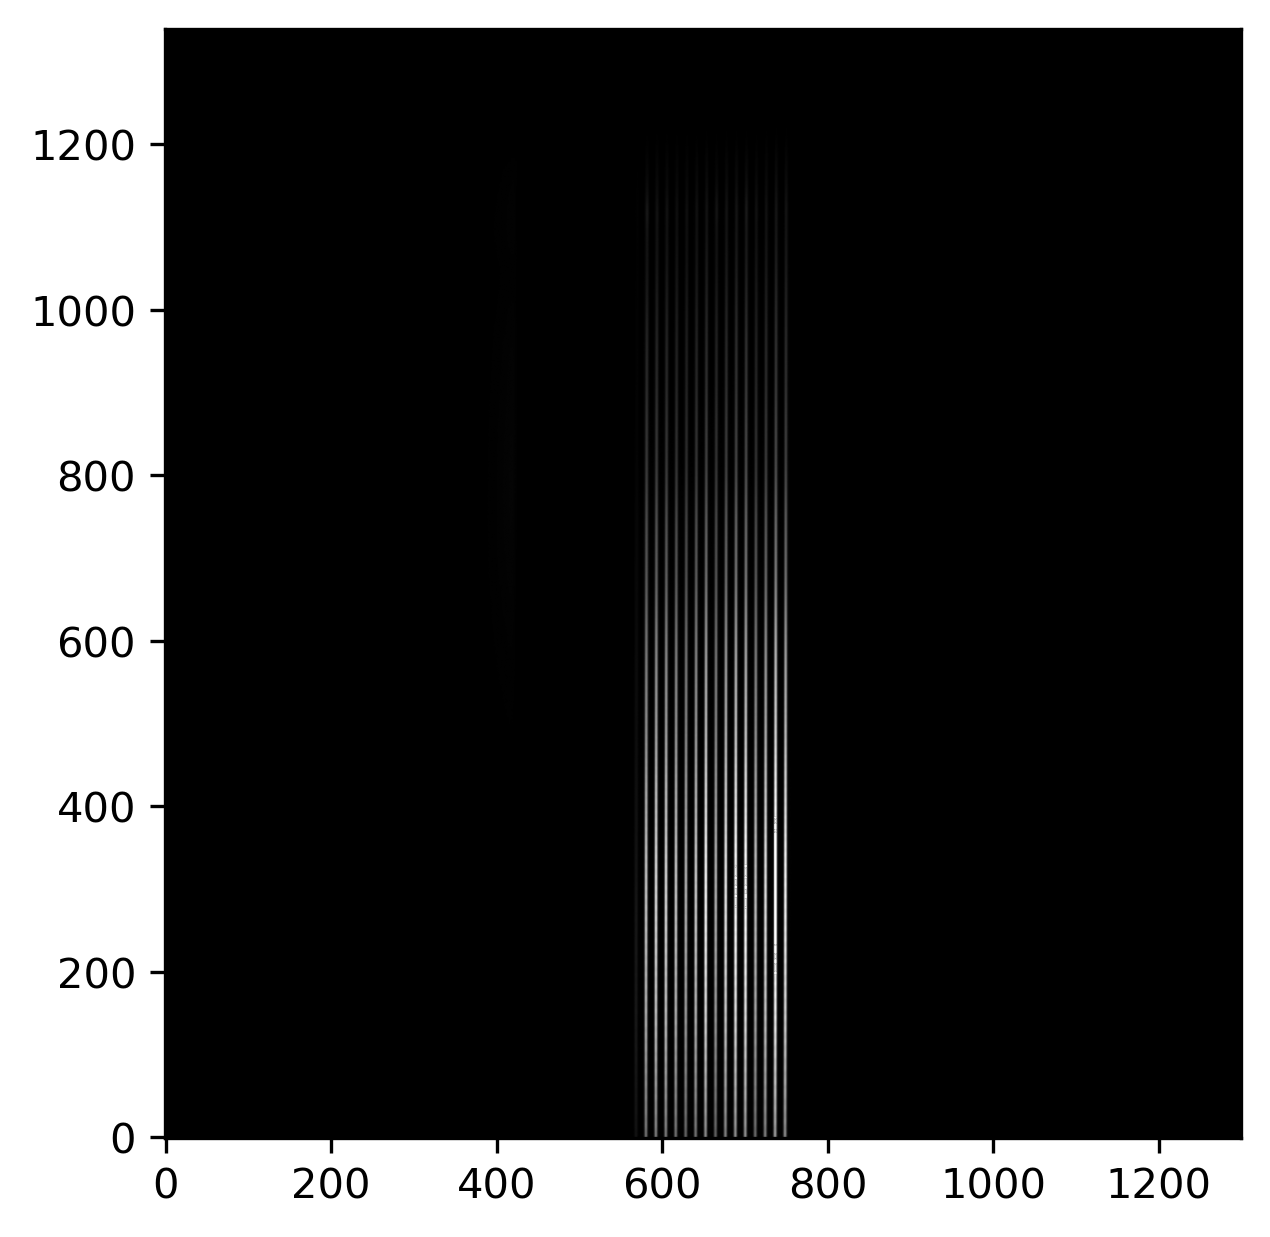

In [6]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode="READ")
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 6)

plt.imshow(img_data, cmap="gray", origin="lower")
plt.show()

Check the instrument code of the image object to ensure it is correctly identified.

In [7]:
im.get_instrument_code()

99

Run `make_tlm` (Make Tramline Map) to identify the positions of the fiber traces across the CCD.

In [8]:
make_tlm(args)

INFO:kspecdr.tlm.make_tlm:Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.tlm.make_tlm:Instrument code: 99
INFO:kspecdr.tlm.make_tlm:Starting tramline map generation for non-2DF instrument
INFO:kspecdr.tlm.make_tlm:Fibres officially in use: 16
INFO:kspecdr.tlm.make_tlm:Fibres potentially able: 0
INFO:kspecdr.tlm.make_tlm:Fibres officially dead: 0
INFO:kspecdr.tlm.make_tlm:Max number of traces: 16
INFO:kspecdr.tlm.make_tlm:Sweeping image for signs of fibre traces...
INFO:kspecdr.tlm.make_tlm:Processing column 0/1340 (0.0%)
INFO:kspecdr.tlm.make_tlm:Processing column 50/1340 (3.7%)
INFO:kspecdr.tlm.make_tlm:Processing column 100/1340 (7.5%)
INFO:kspecdr.tlm.make_tlm:Processing column 150/1340 (11.2%)
INFO:kspecdr.tlm.make_tlm:Processing column 200/1340

INFO:kspecdr.tlm.make_tlm:Tramline map generation completed
INFO:kspecdr.tlm.make_tlm:Generated tramline map: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits


Load the generated Tramline Map file and check its size.

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
(1340, 16)
(16, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 16)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 16)   float64   


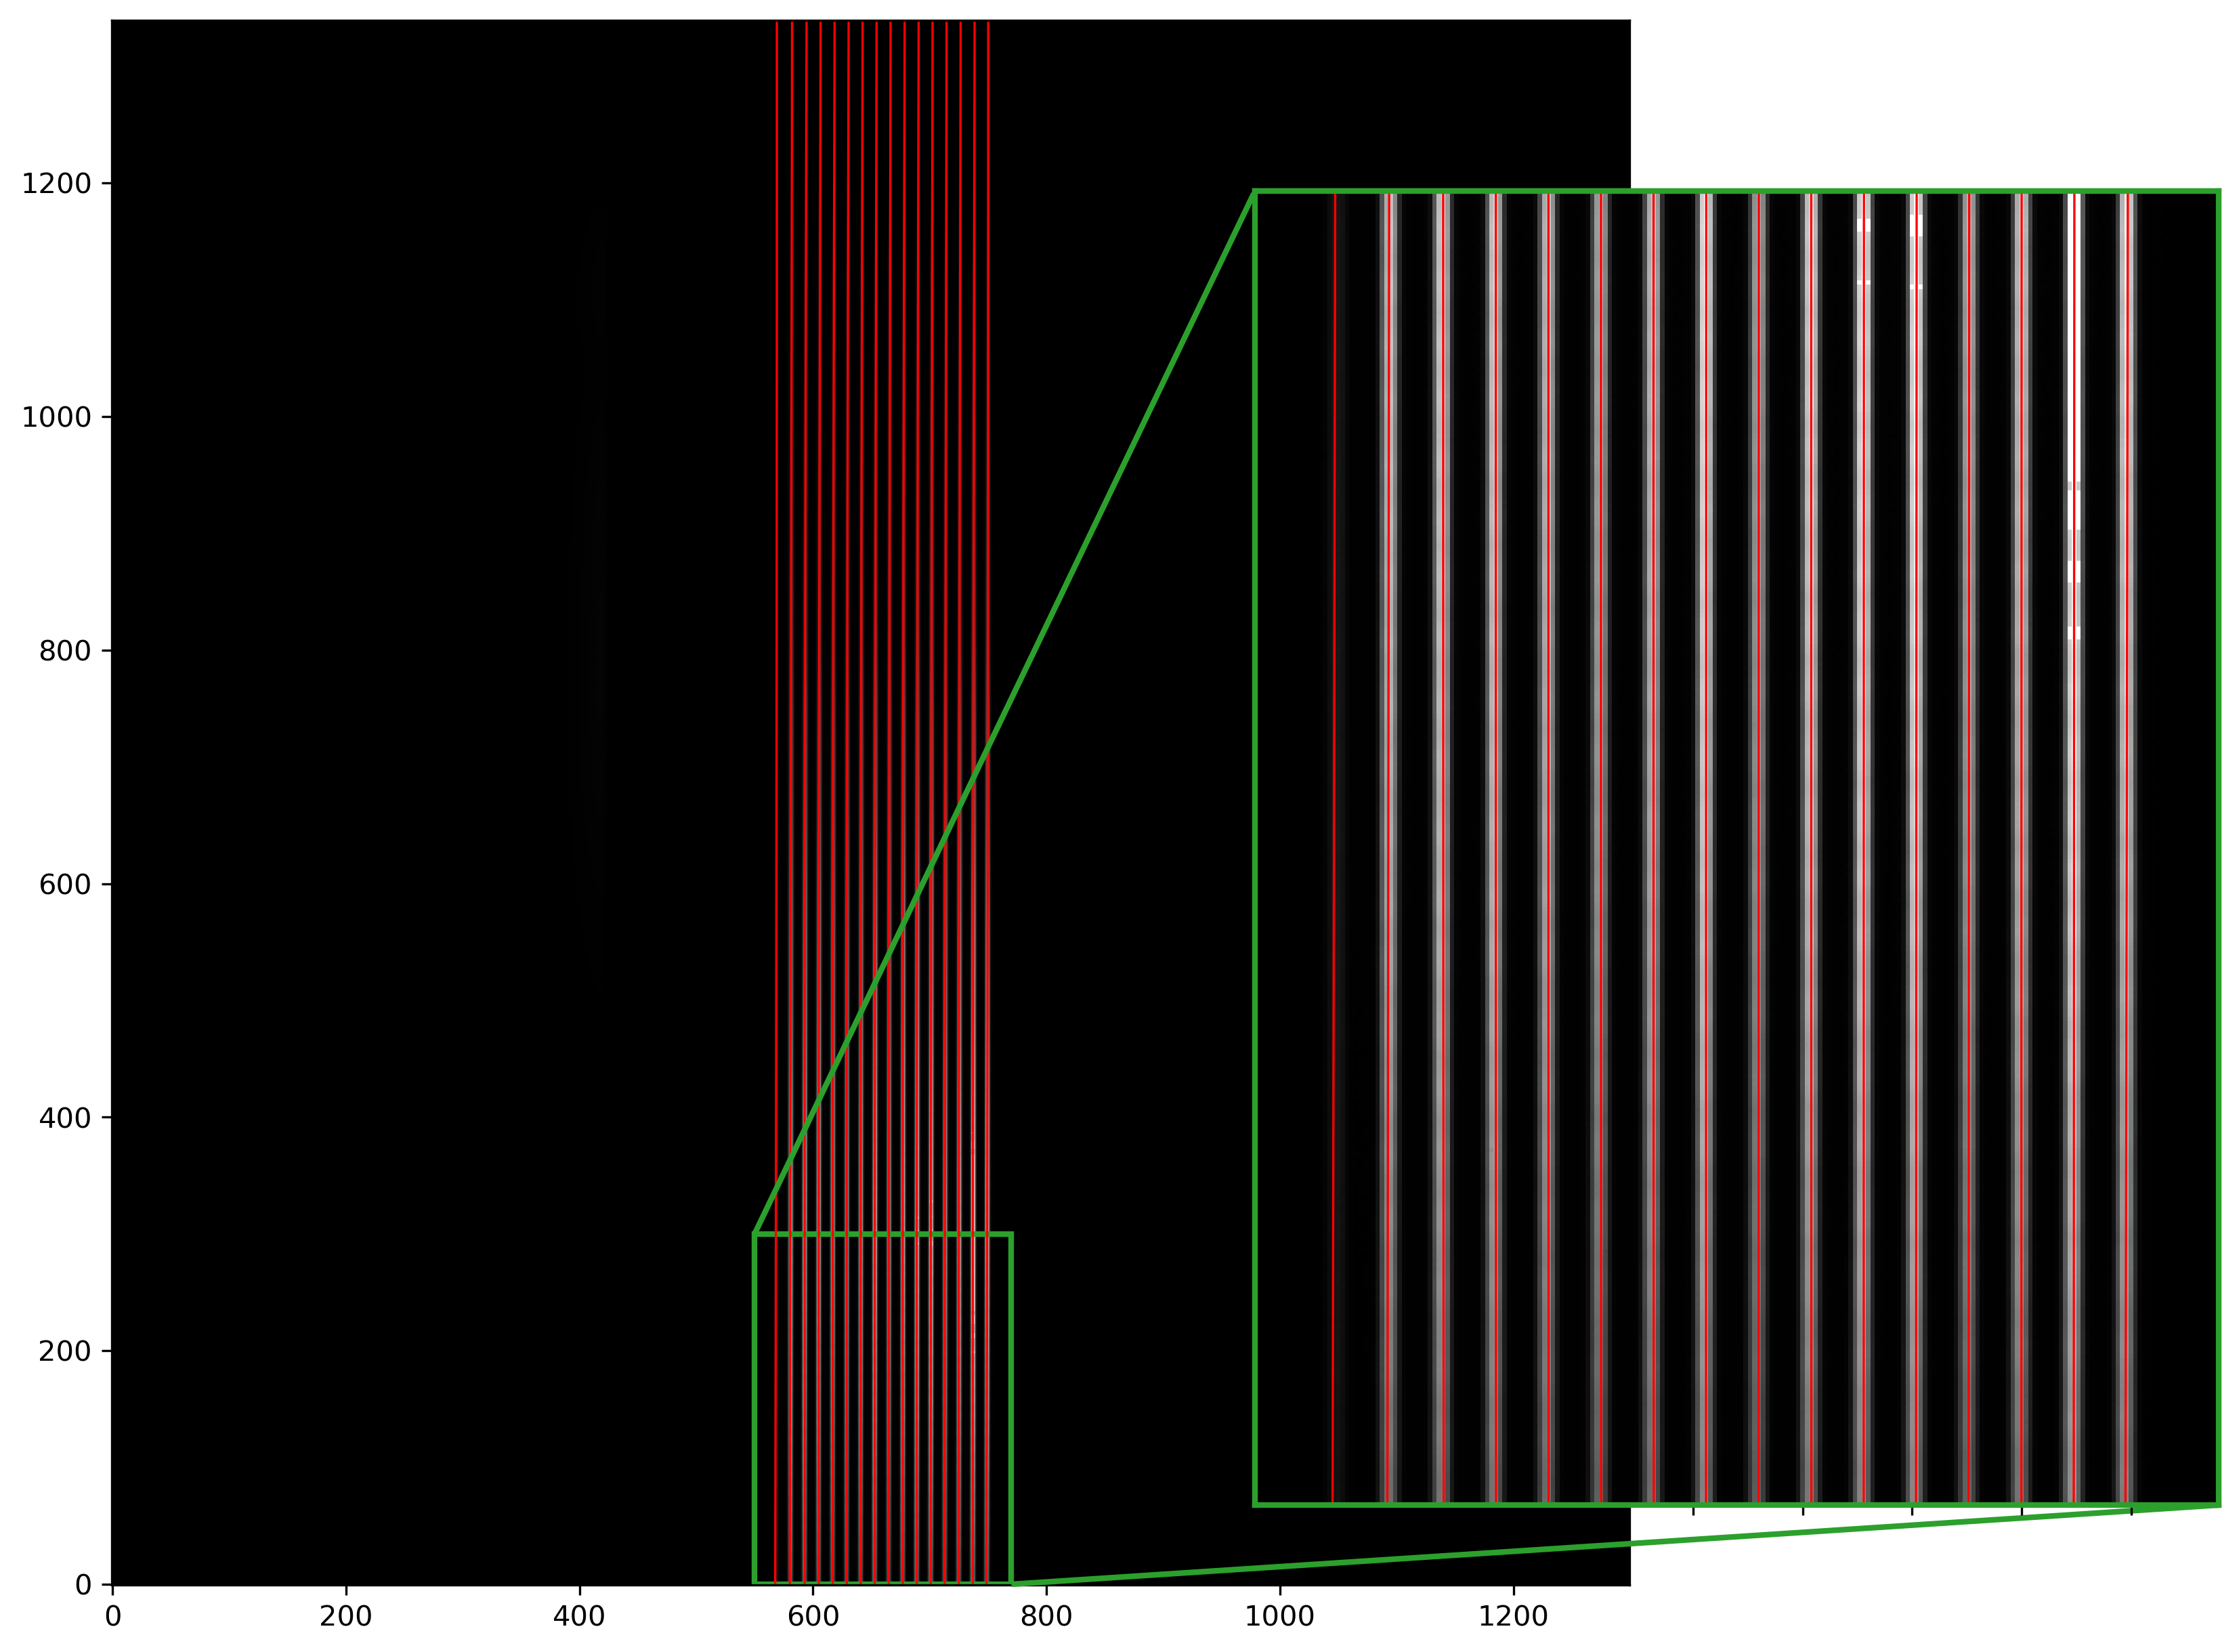

In [9]:
fpath_tlm = new_fpath.parent / (new_fpath.stem + "_tlm.fits")

tlm = ImageFile(fpath_tlm.as_posix(), mode="READ")
tlm.open()
print(tlm.get_size())

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap="gray", origin="lower")
for tl in tlm_data:
    ax.plot(tl, np.arange(tl.shape[0]), c="r", lw=0.8)

# Create inset axes for zoomed region
axins = inset_axes(
    ax,
    width="120%",
    height="120%",
    bbox_to_anchor=(0.7, 0.2, 0.95, 0.7),
    bbox_transform=ax.transAxes,
)
axins.imshow(img_data, cmap="gray", origin="lower")
for tl in tlm_data:
    axins.plot(tl, np.arange(tl.shape[0]), c="r", lw=0.8)
axins.set_xlim(550, 770)
axins.set_ylim(0, 300)
axins.set_xticklabels([])
axins.set_yticklabels([])

# Mark the inset region on the main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="tab:green", lw=2)

for spine in axins.spines.values():
    spine.set_edgecolor("tab:green")
    spine.set_linewidth(2)

Run `make_ex` (Make Extraction) to extract 1D spectra from the 2D image using the spatial information from the Tramline Map. The result is an 'ex' file containing the extracted flux. We then load and display the 2D extracted spectral data.

INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.extract.make_ex:Extraction Method: TRAM
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.extract.make_ex:Per

INFO:kspecdr.extract.make_ex:Written extracted file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   
  3  FIBRES        1 BinTableHDU     13   16R x 2C   [1A, 20A]   


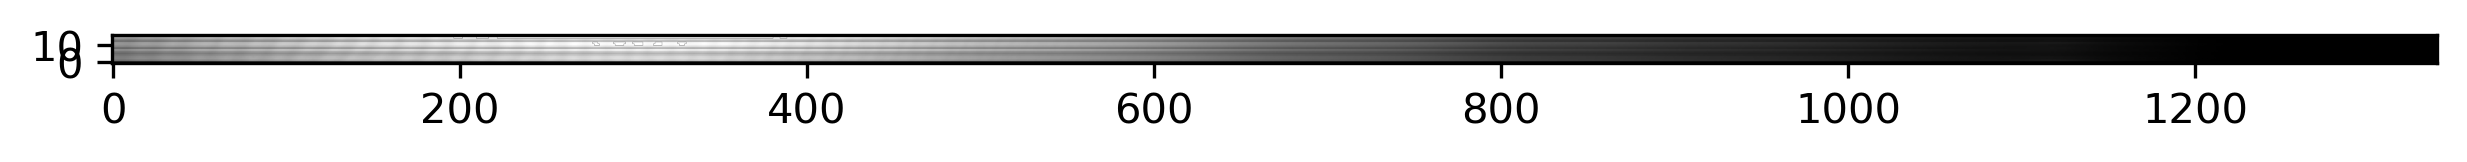

In [10]:
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

args["EXTRAC_FILENAME"] = fpath_ex.as_posix()
args["TLMAP_FILENAME"] = fpath_tlm.as_posix()

make_ex(args)

hdul = fits.open(fpath_ex)
hdul.info()

flat_ex = hdul[0].data

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(flat_ex, cmap="gray", origin="lower")
plt.show()

Plot the extracted spectrum for a single fiber (Fiber 2) to verify the extraction quality.

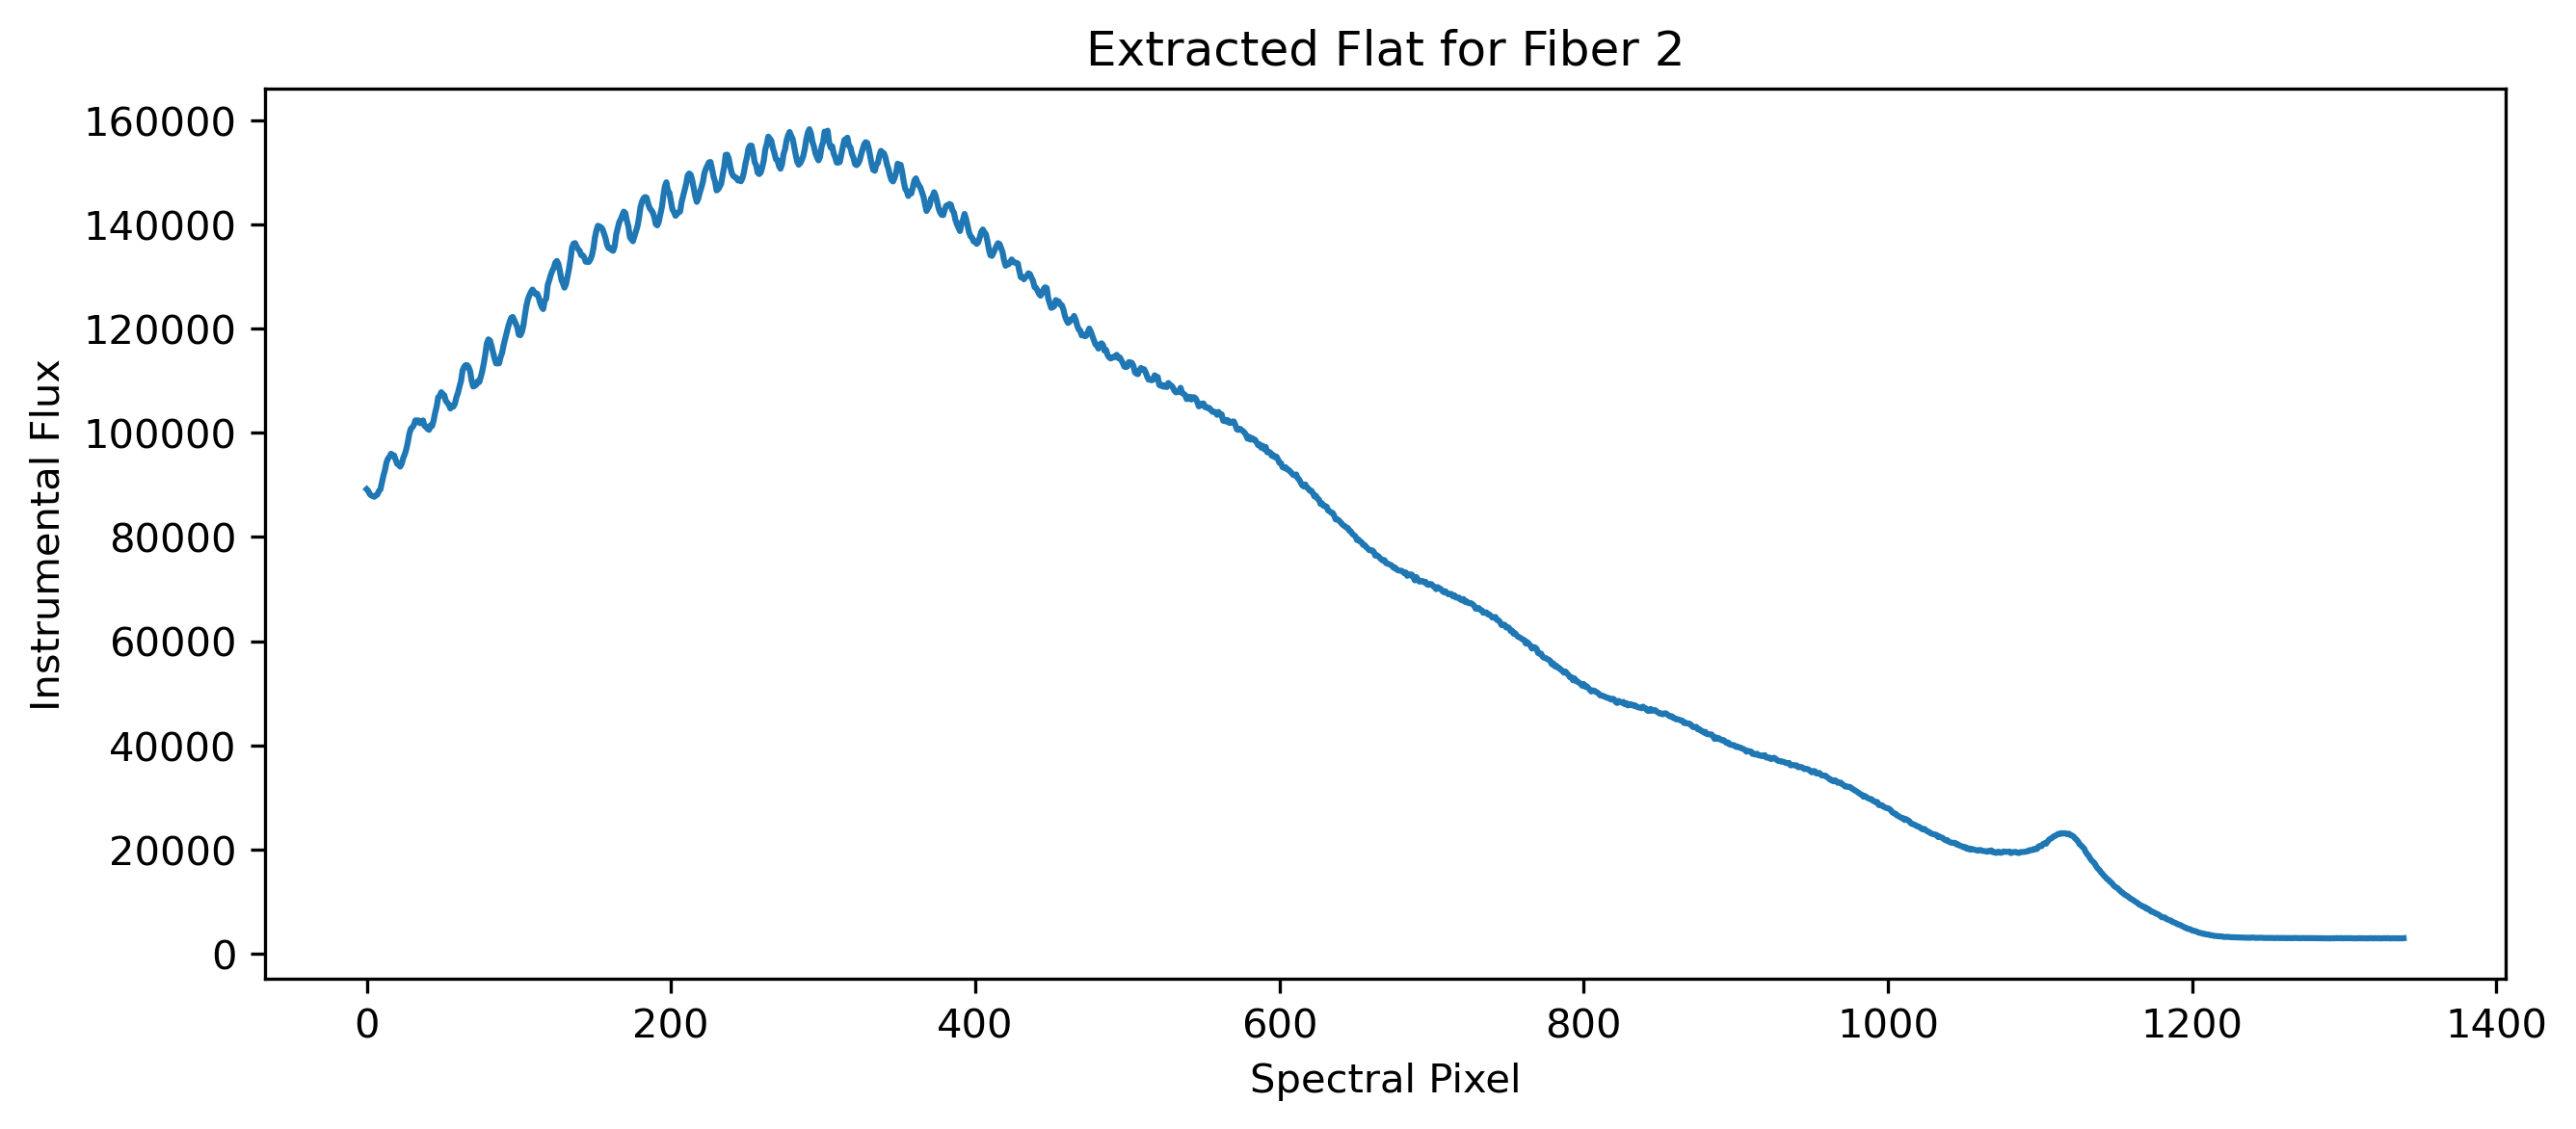

In [11]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(flat_ex[1])
ax.set_ylabel("Instrumental Flux")
ax.set_xlabel("Spectral Pixel")
ax.set_title("Extracted Flat for Fiber 2")
plt.show()

Define the list of arc files (Hg, Ne, Kr, Cd) and process each one: convert the header, preprocess with `make_im`, and extract spectra with `make_ex` using the Tramline Map derived from the flat field.

In [12]:
fpaths = [
    TESTDIR / "Hg_paper_150_620_1sec 2025-12-24 12_09_50.fits",
    TESTDIR / "Ne_150_620_0.fits",
    TESTDIR / "Kr_150_620_0.fits",
    TESTDIR / "hgcd 2025-12-24.fits",
]
converted_fpaths = [
    TESTDIR / "Hg_150_620_converted.fits",
    TESTDIR / "Ne_150_620_0_converted.fits",
    TESTDIR / "Kr_150_620_0_converted.fits",
    TESTDIR / "hgcd 2025-12-24_converted.fits",
]


for fpath, converted_fpath in zip(fpaths, converted_fpaths):
    hdul = fits.open(fpath)
    hdr = hdul[0].header
    # cleaned_hdr = sanitize_header_drop_unparsable(hdr)
    new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

    # add fiber table
    add_fiber_table(hdul, n_fibers=16)

    # just use the first frame for now
    hdul[0].data = hdul[0].data[0]
    # make new fits file with new header and fiber table
    new_hdr["NAXIS"] = 2
    new_hdr.remove("NAXIS3")
    hdul[0].header = new_hdr

    new_fpath = converted_fpath
    hdul.writeto(new_fpath, overwrite=True)

    make_im(new_fpath.as_posix(), cosmic_ray_method="NONE", verbose=False)

    fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
    fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
    args = {
        "IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),
    }

    make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits


INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits (mode: UPDATE)
INFO:kspecdr.io.image:Copied fiber table 'FIBRES' from source file


INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.00% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits
INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_im.fits -> /data1/hb

Run `reduce_arcs` to perform wavelength calibration. This function takes the extracted arc files, identifies arc lines, fits a wavelength solution, and combines the results.

In [13]:
hg_raw_fpath = TESTDIR / "Hg_150_620_converted.fits"
hg_im_fpath = hg_raw_fpath.with_stem(hg_raw_fpath.stem + "_im")
hg_ex_fpath = hg_im_fpath.with_stem(hg_raw_fpath.stem + "_ex")
hg_red_fpath = hg_im_fpath.with_stem(hg_raw_fpath.stem + "_red")

ne_raw_fpath = TESTDIR / "Ne_150_620_0_converted.fits"
ne_im_fpath = ne_raw_fpath.with_stem(ne_raw_fpath.stem + "_im")
ne_ex_fpath = ne_im_fpath.with_stem(ne_raw_fpath.stem + "_ex")
ne_red_fpath = ne_im_fpath.with_stem(ne_raw_fpath.stem + "_red")

kr_raw_fpath = TESTDIR / "Kr_150_620_0_converted.fits"
kr_im_fpath = kr_raw_fpath.with_stem(kr_raw_fpath.stem + "_im")
kr_ex_fpath = kr_im_fpath.with_stem(kr_raw_fpath.stem + "_ex")
kr_red_fpath = kr_im_fpath.with_stem(kr_raw_fpath.stem + "_red")

cd_raw_fpath = TESTDIR / "hgcd 2025-12-24_converted.fits"
cd_im_fpath = cd_raw_fpath.with_stem(cd_raw_fpath.stem + "_im")
cd_ex_fpath = cd_im_fpath.with_stem(cd_raw_fpath.stem + "_ex")
cd_red_fpath = cd_im_fpath.with_stem(cd_raw_fpath.stem + "_red")


hg_args = {
    "RAW_FILENAME": hg_raw_fpath.as_posix(),
    "IMAGE_FILENAME": hg_im_fpath.as_posix(),
    "TLMAP_FILENAME": fpath_tlm.as_posix(),
    "EXTRAC_FILENAME": hg_ex_fpath.as_posix(),
    "OUTPUT_FILENAME": hg_red_fpath.as_posix(),
    "USE_GENCAL": True,
    "ARCDIR": WD / "data" / "arc_tables",
    "LAMPNAME": "hgar",
}
ne_args = {
    "RAW_FILENAME": ne_raw_fpath.as_posix(),
    "IMAGE_FILENAME": ne_im_fpath.as_posix(),
    "TLMAP_FILENAME": fpath_tlm.as_posix(),
    "EXTRAC_FILENAME": ne_ex_fpath.as_posix(),
    "OUTPUT_FILENAME": ne_red_fpath.as_posix(),
    "USE_GENCAL": True,
    "ARCDIR": WD / "data" / "arc_tables",
    "LAMPNAME": "ne",
}
kr_args = {
    "RAW_FILENAME": kr_raw_fpath.as_posix(),
    "IMAGE_FILENAME": kr_im_fpath.as_posix(),
    "TLMAP_FILENAME": fpath_tlm.as_posix(),
    "EXTRAC_FILENAME": kr_ex_fpath.as_posix(),
    "OUTPUT_FILENAME": kr_red_fpath.as_posix(),
    "USE_GENCAL": True,
    "ARCDIR": WD / "data" / "arc_tables",
    "LAMPNAME": "kr",
}
cd_args = {
    "RAW_FILENAME": cd_raw_fpath.as_posix(),
    "IMAGE_FILENAME": cd_im_fpath.as_posix(),
    "TLMAP_FILENAME": fpath_tlm.as_posix(),
    "EXTRAC_FILENAME": cd_ex_fpath.as_posix(),
    "OUTPUT_FILENAME": cd_red_fpath.as_posix(),
    "USE_GENCAL": True,
    "ARCDIR": WD / "data" / "arc_tables",
    "LAMPNAME": "cd",
}

wavecal = reduce_arcs([hg_args, ne_args, kr_args, cd_args], get_diagnostic=True)

INFO:kspecdr.extract.reduce_arc:Starting multi-arc reduction for 4 frames.
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_ex.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_ex.fits


INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_ex.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_ex.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_ex.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_ex.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted_ex.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/hgcd 2025-12-24_converted_ex.fits
INFO:kspecdr.extract.reduce_arc:Selected Master Reference Fiber: 8
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_conve

Load the results of the wavelength calibration, including the calibrated spectra and the calibration dictionary containing coefficients and residuals.

In [14]:
ref_fib = 8
ifib = ref_fib - 1

hgar_hdul = fits.open(hg_red_fpath)
hgar_f8 = hgar_hdul[0].data[ifib]
wave = hgar_hdul[2].data[ifib]

ne_hdul = fits.open(ne_red_fpath)
ne_f8 = ne_hdul[0].data[ifib]
kr_hdul = fits.open(kr_red_fpath)
kr_f8 = kr_hdul[0].data[ifib]
cd_hdul = fits.open(cd_red_fpath)
cd_f8 = cd_hdul[0].data[ifib]

coeffs = wavecal["coeffs"]
x_pts = wavecal["x_pts"]
y_pts = wavecal["y_pts"]
residuals = wavecal["residuals"]
outliers = wavecal["outliers"]
lamps = np.array(wavecal["lamps"])

Visualize the results of the wavelength calibration. The plots show the calibrated spectra for reference fiber 8, the residuals of the fit for each lamp, and the global wavelength solution.

INFO:kspecdr.wavecal.arc_io:Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/hgar.arc
INFO:kspecdr.wavecal.arc_io:Read 20 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/hgar.arc
INFO:kspecdr.wavecal.arc_io:Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/ne.arc
INFO:kspecdr.wavecal.arc_io:Read 37 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/ne.arc
INFO:kspecdr.wavecal.arc_io:Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/kr.arc
INFO:kspecdr.wavecal.arc_io:Read 19 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/kr.arc
INFO:kspecdr.wavecal.arc_io:Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/cd.arc
INFO:kspecdr.wavecal.arc_io:Read 6 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/cd.arc


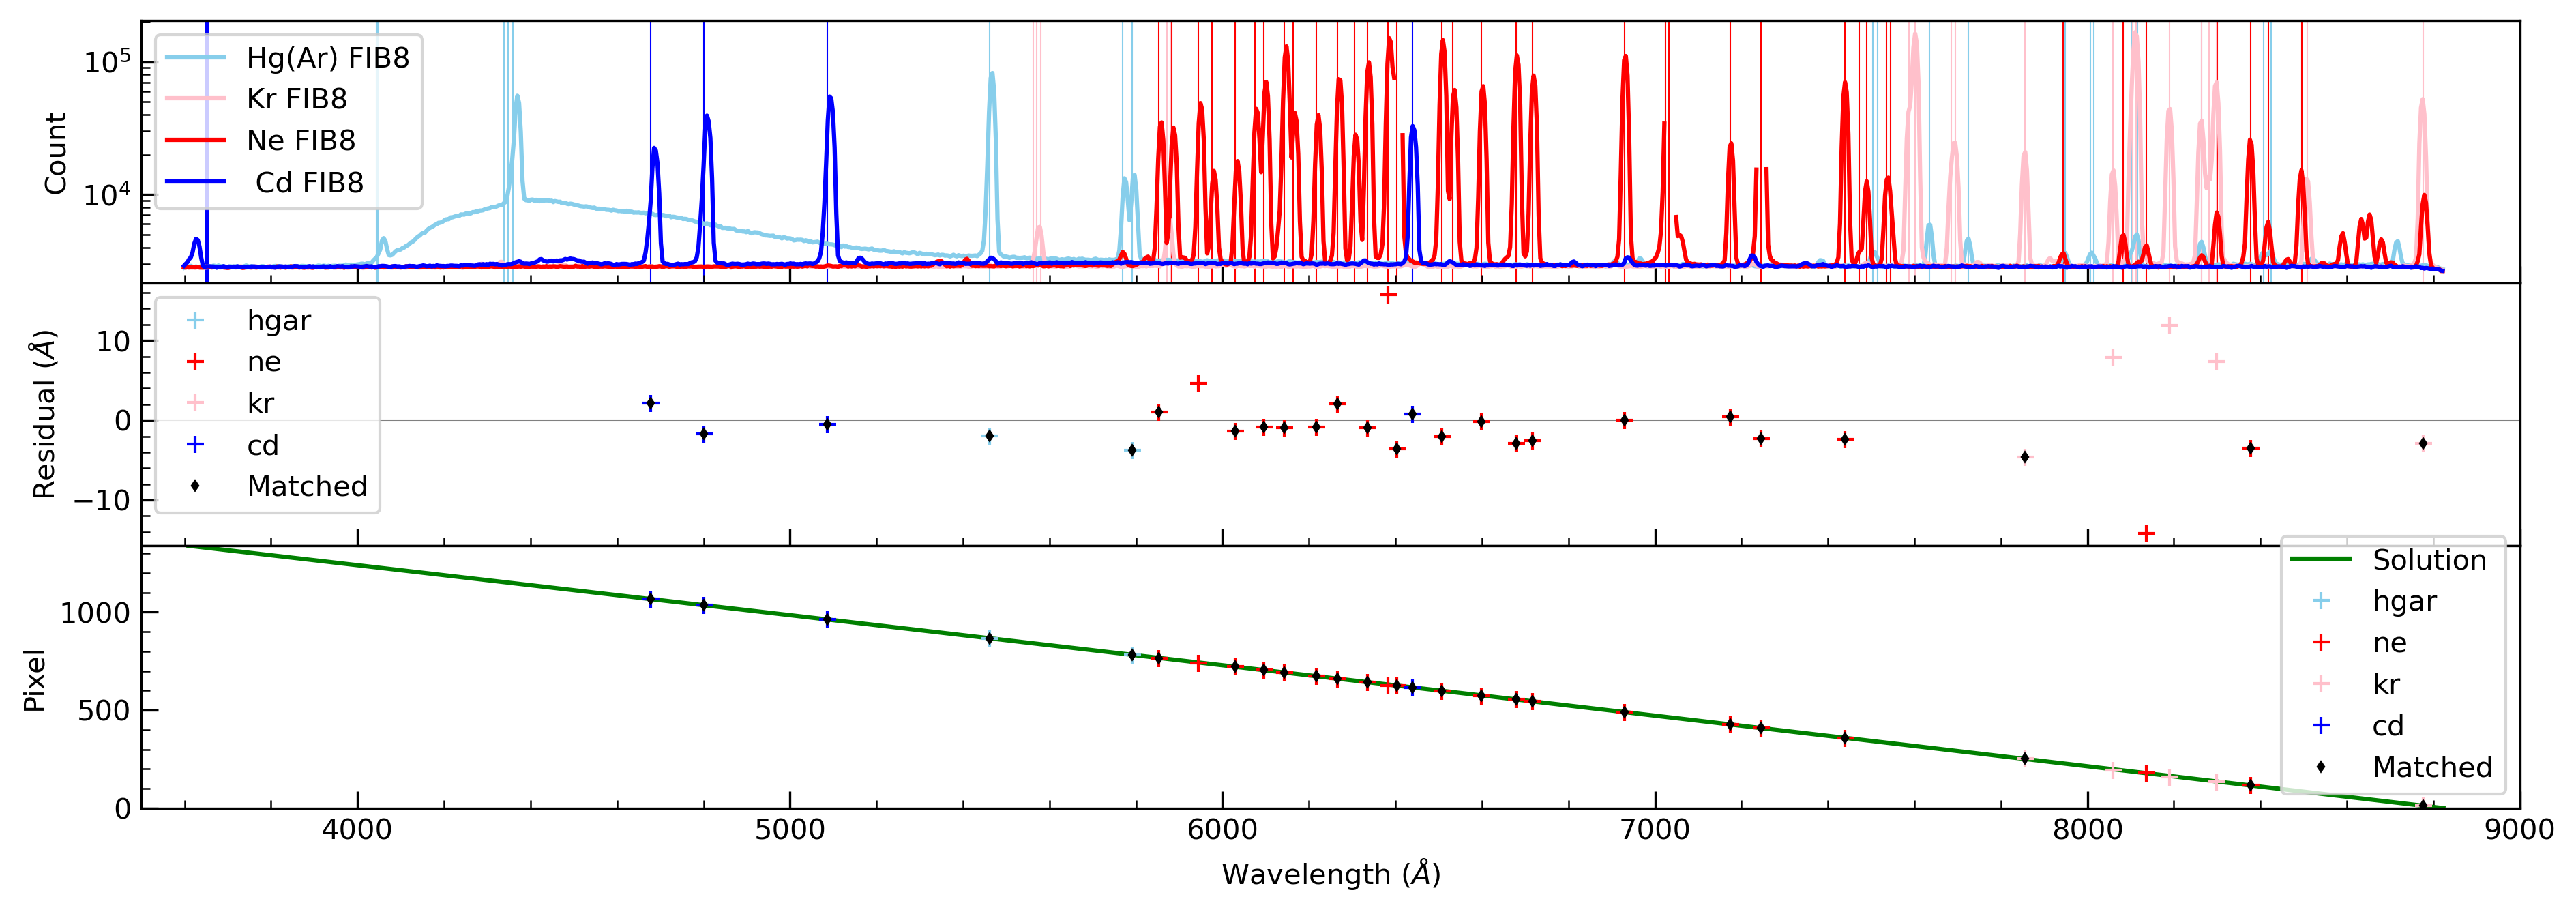

In [15]:
cdir = {"hgar": "skyblue", "ne": "red", "kr": "pink", "cd": "blue"}

fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
ax = axes[0]
ax.plot(wave, hgar_f8, label="Hg(Ar) FIB8", c="skyblue")
ax.plot(wave, kr_f8, label="Kr FIB8", c="pink")
ax.plot(wave, ne_f8, label="Ne FIB8", c="red")
ax.plot(wave, cd_f8, label=" Cd FIB8", c="blue")

nx = 2
xvec = np.array([3000, 9000])
for lamp in ["hgar", "ne", "kr", "cd"]:
    wlist, ilist, labels, nlist = read_arc_file(
        nx, xvec, lamp, arc_dir=WD / "data" / "arc_tables"
    )
    for i in range(len(wlist)):
        ax.axvline(wlist[i], color=cdir[lamp], lw=0.5, zorder=0)

ax.legend()
ax.set_yscale("log")
ax.set_xlim(3500, 9000)
ax.set_ylabel("Count")

ax = axes[1]
for lamp in ["hgar", "ne", "kr", "cd"]:
    xs = x_pts[lamps == lamp]
    ys = y_pts[lamps == lamp]
    res = residuals[lamps == lamp]
    out = outliers[lamps == lamp]
    ax.plot(ys, res, label=lamp, c=cdir[lamp], ls="", marker="+")
ax.plot(
    y_pts[~outliers],
    residuals[~outliers],
    c="k",
    ls="",
    marker="d",
    ms=2,
    label="Matched",
)
ax.legend()
ax.axhline(0, c="gray", lw=0.5, zorder=0)
ax.set_ylabel(r"Residual ($\AA$)")

ax = axes[2]
xx = np.arange(1340)
yy = np.polyval(coeffs, xx)
ax.plot(yy, xx, label="Solution", c="green")
for lamp in ["hgar", "ne", "kr", "cd"]:
    xs = x_pts[lamps == lamp]
    ys = y_pts[lamps == lamp]
    out = outliers[lamps == lamp]
    ax.plot(ys, xs, label=lamp, c=cdir[lamp], ls="", marker="+")
ax.plot(
    y_pts[~outliers], x_pts[~outliers], c="k", ls="", marker="d", ms=2, label="Matched"
)
ax.legend()
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Pixel")
ax.set_xlim(3500, 9000)
ax.set_ylim(0, len(wave))
ax.legend()

for ax in axes:
    # minor ticks direction in
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in")
    ax.tick_params(which="major", length=6)
    ax.tick_params(which="minor", length=3)

fig.subplots_adjust(hspace=0.0)

```{important} To-dos
1. Saturated pixels are not properly handled, making the fit unstable. **We have to test the uniformity of the lamp across the fibers and optimized exposure times for each lamp.**
2. The available lines in the short wavelength range are overlapped with each other, making it difficult to identify the lines. Allowing the use of blended lines might be helpful.
3. Check the wavelength of the line atlas to see if there are more precise values.
4. The line atlas is not complete, so some lines are not included. Including more lines with reliable intensity might help.
```